## Startup


In [2]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

## Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as *cfg.case* and the hyperparameters and implementation of the attack as *cfg.attack*. All parameters can be modified below, or overriden with *overrides=* as if they were cmd-line arguments.

In [3]:
cfg = breaching.get_config(overrides=["case=4_fedavg_small_scale", "case/data=CIFAR10"])
      
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

C:\Users\asdas\anaconda3\envs\venv\lib\site-packages\breaching\__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case fedavg_small_scale with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

## Modify config options here

Using *.attribute* you can access and modify any of these configurations for the attack, or the case:

In [4]:
print(f"cfg experiment: ", cfg.case['name'])
print(f"cfg model: ", cfg.case['model'])
print(f"DATA: ", cfg.case['data']['name'])
print(f"IMPLEMENTATION: ", cfg.case['impl'])
print(f"USER: ", cfg.case['user'])
print(f"SERVER: ", cfg.case['server'])
print(f"ATTACK: ", cfg.attack)

cfg experiment:  fedavg_small_scale
cfg model:  ResNet18
DATA:  CIFAR10
IMPLEMENTATION:  {'shuffle': False, 'sample_with_replacement': False, 'dtype': 'float', 'non_blocking': True, 'sharing_strategy': 'file_descriptor', 'benchmark': True, 'deterministic': False, 'pin_memory': True, 'threads': 0, 'persistent_workers': False, 'mixed_precision': False, 'grad_scaling': True, 'JIT': None, 'validate_every_nth_step': 10, 'checkpoint': {'name': None, 'save_every_nth_step': 10}, 'enable_huggingface_offline_mode': False}
USER:  {'user_type': 'local_update', 'user_idx': 0, 'num_data_points': 4, 'provide_buffers': False, 'provide_labels': False, 'provide_num_data_points': True, 'local_diff_privacy': {'gradient_noise': 0.0, 'input_noise': 0.0, 'distribution': 'laplacian', 'per_example_clipping': 0.0}, 'num_local_updates': 4, 'num_data_per_local_update_step': 1, 'local_learning_rate': 0.001, 'provide_local_hyperparams': True}
SERVER:  {'name': 'honest_but_curious', 'pretrained': True, 'model_state'

In [5]:
cfg.case.data.partition="random"
cfg.case.user.user_idx = 1
cfg.case.model ='resnet18'
cfg.case.server.pretrained = True
cfg.case.user.provide_labels = True
# These settings govern the total amount of user data and how it is used over multiple local update steps:
cfg.case.user.num_data_points = 1  # Default 4 [n in fedAVG]
cfg.case.user.num_local_updates = 1  # Default 4 [E in fedAVG]
cfg.case.user.num_data_per_local_update_step = 1  # Default 2 [B in fedAVG]
cfg.case.user.local_learning_rate = 1e-4 # Default  1e-3 
cfg.case.user.provide_local_hyperparams = True # Default True

# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 1e-4 # Default 1e-3
cfg.attack.optim.max_iterations = 10000 # Default 24000
cfg.attack.optim.step_size = 1

In [6]:
print(f"cfg model: ", cfg.case['model'])
print(f"ATTACK: ", cfg.attack)
print(f"SERVER: ", cfg.case['server'])
print(f"USER: ", cfg.case['user'])

cfg model:  resnet18
ATTACK:  {'type': 'invertinggradients', 'attack_type': 'optimization', 'label_strategy': 'bias-corrected', 'text_strategy': 'run-embedding', 'token_recovery': 'from-labels', 'objective': {'type': 'cosine-similarity', 'scale': 1.0, 'task_regularization': 0.0}, 'restarts': {'num_trials': 1, 'scoring': 'cosine-similarity'}, 'init': 'randn', 'normalize_gradients': False, 'optim': {'optimizer': 'adam', 'signed': 'hard', 'step_size': 1, 'boxed': True, 'max_iterations': 10000, 'step_size_decay': 'step-lr', 'langevin_noise': 0.0, 'warmup': 0, 'grad_clip': None, 'callback': 1000}, 'augmentations': None, 'differentiable_augmentations': False, 'regularization': {'total_variation': {'scale': 0.0001, 'inner_exp': 1, 'outer_exp': 1}}, 'impl': {'dtype': 'float', 'mixed_precision': False, 'JIT': None}}
SERVER:  {'name': 'honest_but_curious', 'pretrained': True, 'model_state': 'default', 'provide_public_buffers': True, 'has_external_data': False, 'num_queries': 1}
USER:  {'user_typ

## Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [7]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture resnet18 loaded with 11,173,962 parameters and 0 buffers.
Overall this is a data ratio of    3637:1 for target shape [1, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
    Local FL Setup:
        Number of local update steps: 1
        Data per local update step: 1
        Local learning rate: 0.0001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with

In [8]:
print(model)

VisionContainer(
  (model): ResNet(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(2, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (layers): Sequential(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): GroupNorm(2, 64, eps=1e-05, affine=True)
          (nonlin): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): GroupNorm(2, 64, eps=1e-05, affine=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): GroupNorm(2, 64, eps=1e-05, affine=True)
          (nonlin): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2)

## Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a **server_payload** and the user computes an update based on their private local data. This user update is **shared_data** and contains, for example, the parameter gradient of the model in the simplest case. **true_user_data** is also returned by *.compute_local_updates*, but of course not forwarded to the server or attacker and only used for the analysis.

In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


## Reconstruct user data

Now we launch the attack, reconstructing user data based on only the **server_payload** and **the shared_data**.

You can interrupt the computation early to see a partial solution.

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 0.0861 |  Task loss: 2.4151 | T: 0.29s
| It: 1001 | Rec. loss: 0.0355 |  Task loss: 2.4145 | T: 91.13s
| It: 2001 | Rec. loss: 0.0340 |  Task loss: 2.3198 | T: 82.12s
| It: 3001 | Rec. loss: 0.0341 |  Task loss: 2.3792 | T: 82.24s
| It: 4001 | Rec. loss: 0.0171 |  Task loss: 2.3031 | T: 80.84s
| It: 5001 | Rec. loss: 0.0162 |  Task loss: 2.3353 | T: 85.15s
| It: 6001 | Rec. loss: 0.0172 |  Task loss: 2.3436 | T: 89.16s
| It: 7001 | Rec. loss: 0.0094 |  Task loss: 2.3018 | T: 88.64s
| It: 8001 | Rec. loss: 0.0095 |  Task loss: 2.3272 | T: 88.69s
| It: 9001 | Rec. loss: 0.0070 |  Task loss: 2.2921 | T: 88.03s
| It: 10000 | Rec. loss: 0.0073 |  Task loss: 2.3089 | T: 88.61s
Optimal candidate solution with rec. loss 0.0067 selected.


Next we'll evaluate metrics, comparing the *reconstructed_user_data* to the *true_user_data*.

In [11]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

C:\Users\asdas\anaconda3\envs\venv\lib\site-packages\breaching\analysis\metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(


Files already downloaded and verified
METRICS: | MSE: 0.0013 | PSNR: 28.77 | FMSE: 1.0227e-04 | LPIPS: 0.00|
 R-PSNR: 28.77 | IIP-pixel: 100.00% | SSIM: nan | max R-PSNR: 28.77 | max SSIM: nan | Label Acc: 100.00%


And finally, we also plot both the reconstructed data and original data:

In [12]:
# The function user.plot doesn't work properly unless you make that correction
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

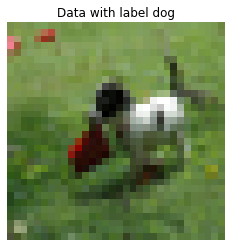

In [13]:
user.plot(true_user_data,  print_labels=True, scale=True)

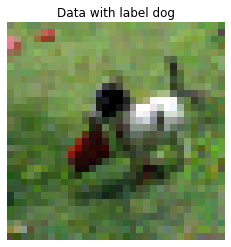

In [14]:
user.plot(reconstructed_user_data,print_labels=True, scale=True)